This notebook is a demonstration of the integer QAOA.

Revelent paper:

* Integer Programming from Quantum Annealing and Open Quantum Systems

* Quantum Portfolio Optimization: Binary encoding of discrete variables for QAOA with hard constraint

In [13]:
import tensorcircuit as tc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from functools import partial
import time
import scipy.optimize as optimize

from tensorcircuit.templates.ansatz import QAOA_ansatz_for_Ising
from tensorcircuit.templates.conversions import QUBO_to_Ising
from tensorcircuit.applications.optimization import QUBO_QAOA, QAOA_loss
from tensorcircuit.applications.finance.portfolio import StockData, QUBO_from_portfolio

K = tc.set_backend("tensorflow")

# Brute-force

In [14]:
def symmetric_matrix_generator(dim: int) -> np.array:
    """
    Generate a random symmetric matrix with a give dimension.
    args:
        dim: the number of dimension
    return:
        mat: a symmetric matrix
    """
    mat = np.random.rand(dim**2)
    mat = (mat - 0.5) * 2
    mat = mat.reshape(dim, dim)
    mat = np.triu(mat)
    mat += mat.T - np.diag(mat.diagonal())

    return mat

Q = symmetric_matrix_generator(6)
Q

array([[ 0.36387044,  0.98398998,  0.77664382, -0.57022145, -0.8271865 ,
        -0.17470179],
       [ 0.98398998, -0.74150159, -0.83136848,  0.96863776,  0.59585787,
         0.10660856],
       [ 0.77664382, -0.83136848, -0.07874158, -0.34773698, -0.1300613 ,
        -0.43438872],
       [-0.57022145,  0.96863776, -0.34773698,  0.66109934, -0.02911056,
        -0.4202277 ],
       [-0.8271865 ,  0.59585787, -0.1300613 , -0.02911056,  0.23173986,
         0.02608603],
       [-0.17470179,  0.10660856, -0.43438872, -0.4202277 ,  0.02608603,
         0.42564159]])

In [15]:
"""Q = np.array(
    [
        [0.88948032, -0.07234145, -0.18161475, -0.53710716, 0.33096931, -0.26108493],
        [-0.07234145, -0.09541496, 0.68429927, 0.5039359, 0.47133678, 0.65393151],
        [-0.18161475, 0.68429927, -0.26816208, -0.15116385, -0.31595842, 0.44916078],
        [-0.53710716, 0.5039359, -0.15116385, -0.58175722, -0.34328656, -0.31502359],
        [0.33096931, 0.47133678, -0.31595842, -0.34328656, -0.12711979, 0.52694774],
        [-0.26108493, 0.65393151, 0.44916078, -0.31502359, 0.52694774, -0.63838229],
    ]
)"""

# [0.4, 0.0, 1.0, 1.0, 1.0, 0.0]

'Q = np.array(\n    [\n        [0.88948032, -0.07234145, -0.18161475, -0.53710716, 0.33096931, -0.26108493],\n        [-0.07234145, -0.09541496, 0.68429927, 0.5039359, 0.47133678, 0.65393151],\n        [-0.18161475, 0.68429927, -0.26816208, -0.15116385, -0.31595842, 0.44916078],\n        [-0.53710716, 0.5039359, -0.15116385, -0.58175722, -0.34328656, -0.31502359],\n        [0.33096931, 0.47133678, -0.31595842, -0.34328656, -0.12711979, 0.52694774],\n        [-0.26108493, 0.65393151, 0.44916078, -0.31502359, 0.52694774, -0.63838229],\n    ]\n)'

In [16]:
n = 10

feasible_states = []
for x1 in range(n+1):
    for x2 in range(n+1):
        for x3 in range(n+1):
            for x4 in range(n+1):
                for x5 in range(n+1):
                    for x6 in range(n+1):
                        if True:#(x1 + x2 + x3 + x4 + x5 + x6) <= 4 * n:
                            feasible_states.append(
                                [x1 / n, x2 / n, x3 / n, x4 / n, x5 / n, x6 / n]
                            )

In [17]:
all_results = []
for state in feasible_states:
    all_results.append(np.dot(state, np.dot(Q, state)))

In [18]:
print(np.min(all_results), feasible_states[np.argmin(all_results)])

-2.7350177444680166 [0.0, 1.0, 1.0, 0.0, 0.0, 0.8]


# QAOA

In [19]:
def print_Q_cost(Q, wrap=False, reverse=False):
    n_stocks = len(Q)
    states = []
    for i in range(2**n_stocks):
        a = f"{bin(i)[2:]:0>{n_stocks}}"
        n_ones = 0
        for j in a:
            if j == "1":
                n_ones += 1
        states.append(a)

    cost_dict = {}
    for selection in states:
        x = np.array([int(bit) for bit in selection])
        cost_dict[selection] = np.dot(x, np.dot(Q, x))
    cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
    if reverse == True:
        cost_sorted = dict(
            sorted(cost_dict.items(), key=lambda item: item[1], reverse=True)
        )
    num = 0
    print("\n-------------------------------------")
    print("    selection\t  |\t  cost")
    print("-------------------------------------")
    for k, v in cost_sorted.items():
        print("%10s\t  |\t%.4f" % (k, v))
        num += 1
        if (num >= 8) & (wrap == True):
            break
    print("     ...\t  |\t  ...")
    print("-------------------------------------")

In [20]:
print_Q_cost(Q, wrap=True)


-------------------------------------
    selection	  |	  cost
-------------------------------------
    011001	  |	-2.7129
    101111	  |	-2.6582
    011000	  |	-2.4830
    100111	  |	-2.3084
    011101	  |	-1.6505
    100110	  |	-1.5963
    011011	  |	-1.4974
    001111	  |	-1.4311
     ...	  |	  ...
-------------------------------------


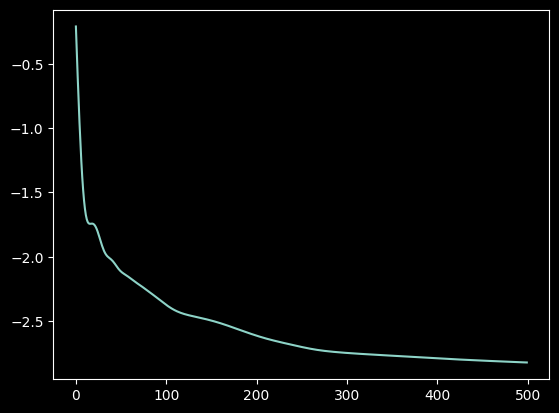

In [21]:
iterations = 500
nlayers = 12
loss_list = []

# define a callback function to recode the loss
def record_loss(loss, params):
    loss_list.append(loss)

# apply QAOA on this portfolio optimization problem
final_params = QUBO_QAOA(Q, nlayers, iterations, callback=record_loss)

p = plt.plot(loss_list)

the expectation value of each qubit:
0.4412977993488312
0.6102265268564224
0.02586662769317627
0.4016197919845581
0.41468545794487
0.033747971057891846

the states with highest probabilities (in reverse order):
101110
100111
101111


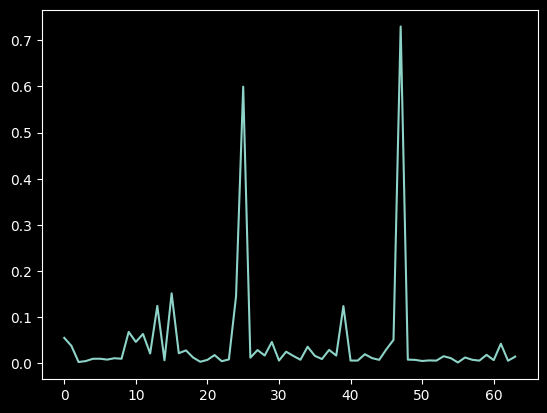

In [22]:
portfolio_pauli_terms, portfolio_weights, portfolio_offset = QUBO_to_Ising(Q)
c_final = QAOA_ansatz_for_Ising(
    final_params, nlayers, portfolio_pauli_terms, portfolio_weights
)

plt.plot(abs(c_final.state().numpy()))
print("the expectation value of each qubit:")
for i in range(6):
    print(abs(c_final.expectation((tc.gates.z(), [i])).numpy()+1)/2)
print("\nthe states with highest probabilities (in reverse order):")
for i in range(-3, 0):
    print(np.binary_repr(np.argsort(c_final.state().numpy())[i], width=6))